In [1]:
import Analysis.dataPrep as data_prep
df, df_build_notes, summary_list = data_prep.sickness_table_df()
print('\n'.join(df_build_notes))

Daten erfolgreich in einen DataFrame umgewandelt
Keine fehlenden Daten in der CSV-Datei
Keine nicht-ganzzahligen Werte in den Spalten 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need', 'dafted'
Alle Daten zwischen Start- und Enddatum vorhanden
Alle Spalten ausser 'date' in Integer umgewandelt
Alle Daten in der 'date'-Spalte sind Datetime-Datentyp


In [2]:
for i in summary_list:
    print(i, '\n')


Dataframe Info: 

                      date       n_sick         calls       n_duty   n_sby  \
count                 1152  1152.000000   1152.000000  1152.000000  1152.0   
mean   2017-10-28 12:00:00    68.808160   7919.531250  1820.572917    90.0   
min    2016-04-01 00:00:00    36.000000   4074.000000  1700.000000    90.0   
25%    2017-01-13 18:00:00    58.000000   6978.000000  1800.000000    90.0   
50%    2017-10-28 12:00:00    68.000000   7932.000000  1800.000000    90.0   
75%    2018-08-12 06:00:00    78.000000   8827.500000  1900.000000    90.0   
max    2019-05-27 00:00:00   119.000000  11850.000000  1900.000000    90.0   
std                    NaN    14.293942   1290.063571    80.086953     0.0   

          sby_need       dafted  
count  1152.000000  1152.000000  
mean     34.718750    16.335938  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%      12.250000     0.000000  
max     555.000000   465.000000  
std   

In [3]:
data_prep.describe_data(df)

Werte in der n_sby-Spalte:[90]
Werte in der n_duty-Spalte:[1700 1800 1900]


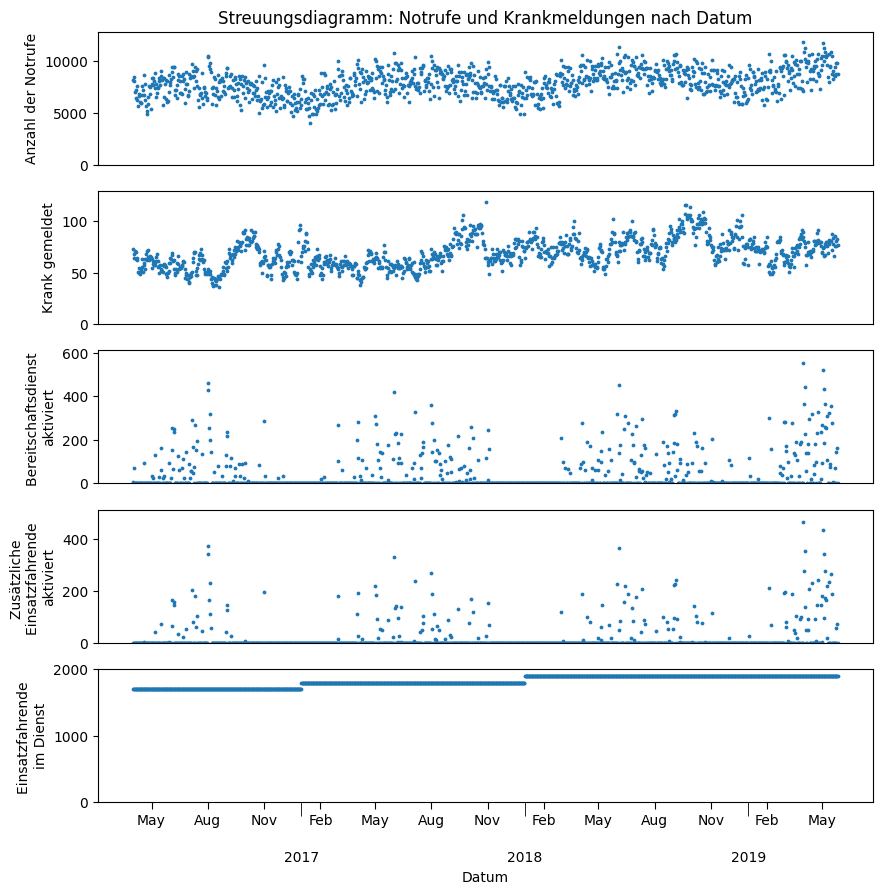

In [4]:
data_prep.overview_scatter(df)

In [5]:
df_2 = data_prep.new_columns(df) # Neue Spalten erstellen
df_2

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,demand,n_sick_adj
0,2016-04-01,73,8154,1700,90,4,0,1631.0,82
1,2016-04-02,64,8526,1700,90,70,0,1706.0,72
2,2016-04-03,68,8088,1700,90,0,0,NaN,76
3,2016-04-04,71,7044,1700,90,0,0,NaN,79
4,2016-04-05,63,7236,1700,90,0,0,NaN,70
...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544,1900,90,0,0,NaN,86
1148,2019-05-24,81,8814,1900,90,0,0,NaN,81
1149,2019-05-25,76,9846,1900,90,146,56,1970.0,76
1150,2019-05-26,83,9882,1900,90,160,70,1977.0,83


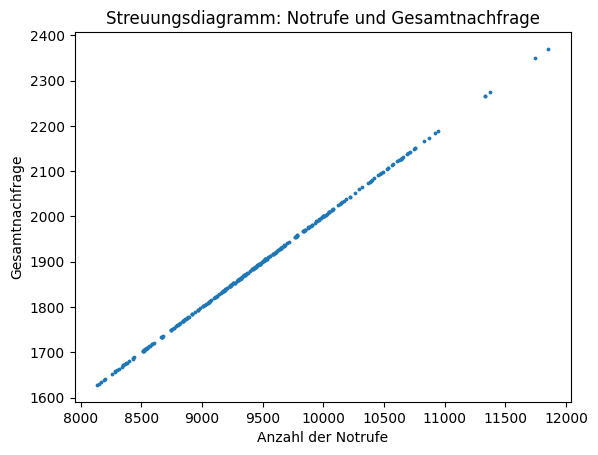

In [6]:
data_prep.demand_vs_calls(df_2)

In [7]:
reg, reg_score, df_demand_predict = data_prep.notrufe_demand_reg(df_2)
reg_score

0.9999955382315575

Aus dem Streuungsdiagramm ist es deutlich klar, dass ein lineares Verhältnis zwischen der Anzahl an Notrufen und der Gesamtnachfrage nach Einsatzfahrenden gibt. Das bedeutet, dass die zwei Hauptfragen mit denen wir uns beschäftigen sollten, sind ob die Anzahl an Anrufen und Krankenstände vorhergesagt kann.

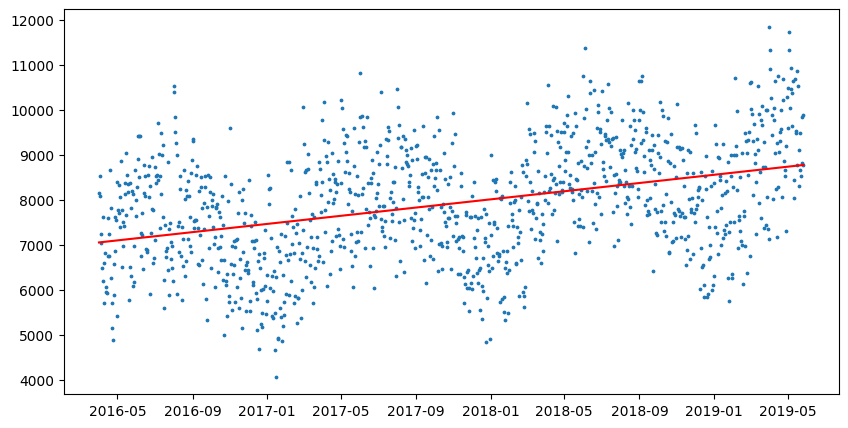

In [17]:
df_demand_predict, ax, reg, reg_score = data_prep.notruf_reg(df_demand_predict)
import matplotlib.pyplot as plt
plt.show()

In [9]:
reg_score

0.148748112671504

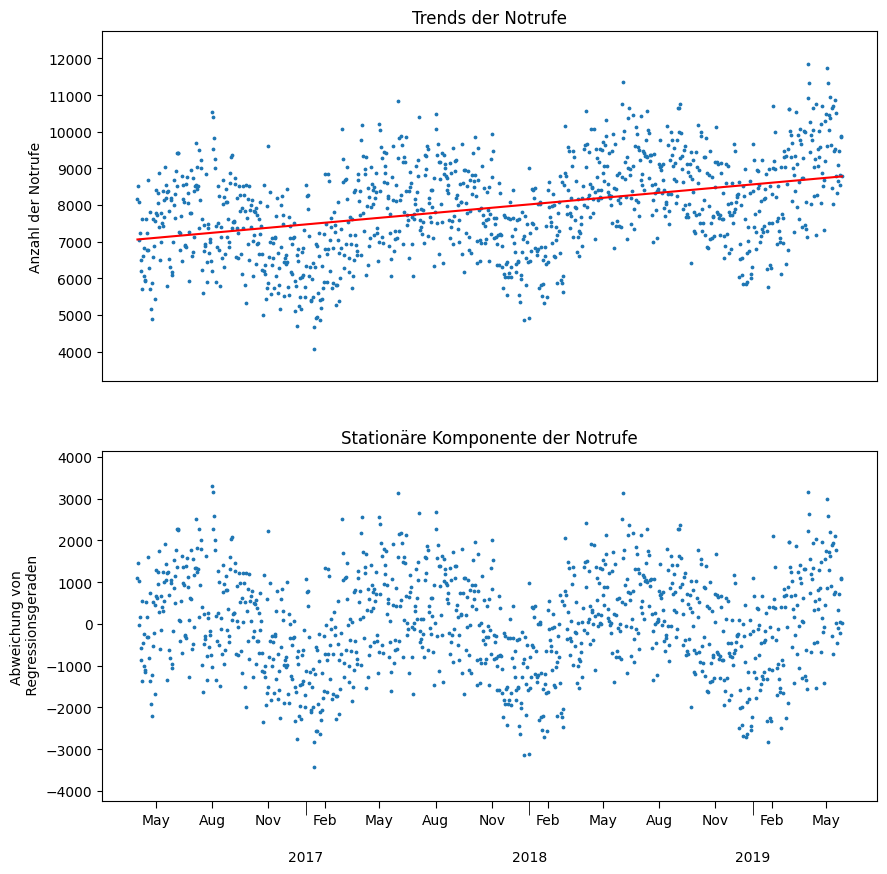

In [10]:
data_prep.no_trend_scatter(df_demand_predict)

In [11]:
df_demand_predict = data_prep.new_columns(df_demand_predict)
df_demand_predict = data_prep.new_features(df_demand_predict)
df_demand_predict

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,demand,n_sick_adj,demand_pred,...,month,year,dayofmonth,weekday,weekofyear,dayofyear,predict_day,season,day,status
0,2016-04-01,73,8154,1700,90,4,0,1631.0,82,1631,...,4,2016,1,4,13,92,2016-03-15,2,1,actual
1,2016-04-02,64,8526,1700,90,70,0,1706.0,72,1706,...,4,2016,2,5,13,93,2016-03-15,2,2,actual
2,2016-04-03,68,8088,1700,90,0,0,NaN,76,1618,...,4,2016,3,6,13,94,2016-03-15,2,3,actual
3,2016-04-04,71,7044,1700,90,0,0,NaN,79,1409,...,4,2016,4,0,14,95,2016-03-15,2,4,actual
4,2016-04-05,63,7236,1700,90,0,0,NaN,70,1448,...,4,2016,5,1,14,96,2016-03-15,2,5,actual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544,1900,90,0,0,NaN,86,1709,...,5,2019,23,3,21,143,2019-04-15,2,1148,actual
1148,2019-05-24,81,8814,1900,90,0,0,NaN,81,1763,...,5,2019,24,4,21,144,2019-04-15,2,1149,actual
1149,2019-05-25,76,9846,1900,90,146,56,1970.0,76,1970,...,5,2019,25,5,21,145,2019-04-15,2,1150,actual
1150,2019-05-26,83,9882,1900,90,160,70,1977.0,83,1977,...,5,2019,26,6,21,146,2019-04-15,2,1151,actual


In [12]:
# Random Forest um die wichtigsten Features zu finden
predictions, feat_gini_importance, results_df, models = data_prep.my_model_options(df_demand_predict)
print(feat_gini_importance.sort_values(ascending=False))

dayofyear     0.483048
dayofmonth    0.259654
weekday       0.137840
weekofyear    0.066068
month         0.034201
year          0.016470
season        0.002720
dtype: float64


In [13]:
print(results_df)

          mse_rf     r2_rf     mse_adabr  r2_adabr
0  912371.943141  0.129587  882002.01109   0.15856


In [14]:
predictions

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,demand,n_sick_adj,demand_pred,...,dayofmonth,weekday,weekofyear,dayofyear,predict_day,season,day,status,randforest_pred,adaboost_pred
0,2016-04-01,73,8154,1700,90,4,0,1631.0,82,1631,...,1,4,13,92,2016-03-15,2,1,actual,1653.638789,1434.850000
1,2016-04-02,64,8526,1700,90,70,0,1706.0,72,1706,...,2,5,13,93,2016-03-15,2,2,actual,919.943141,679.926829
2,2016-04-03,68,8088,1700,90,0,0,NaN,76,1618,...,3,6,13,94,2016-03-15,2,3,actual,834.263657,479.083333
3,2016-04-04,71,7044,1700,90,0,0,NaN,79,1409,...,4,0,14,95,2016-03-15,2,4,actual,1243.053495,1173.287770
4,2016-04-05,63,7236,1700,90,0,0,NaN,70,1448,...,5,1,14,96,2016-03-15,2,5,actual,1052.388062,931.792453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544,1900,90,0,0,NaN,86,1709,...,23,3,21,143,2019-04-15,2,1148,actual,363.924298,225.798046
1148,2019-05-24,81,8814,1900,90,0,0,NaN,81,1763,...,24,4,21,144,2019-04-15,2,1149,actual,84.011417,102.292683
1149,2019-05-25,76,9846,1900,90,146,56,1970.0,76,1970,...,25,5,21,145,2019-04-15,2,1150,actual,-79.816554,-1.417582
1150,2019-05-26,83,9882,1900,90,160,70,1977.0,83,1977,...,26,6,21,146,2019-04-15,2,1151,actual,-367.762482,-355.011236


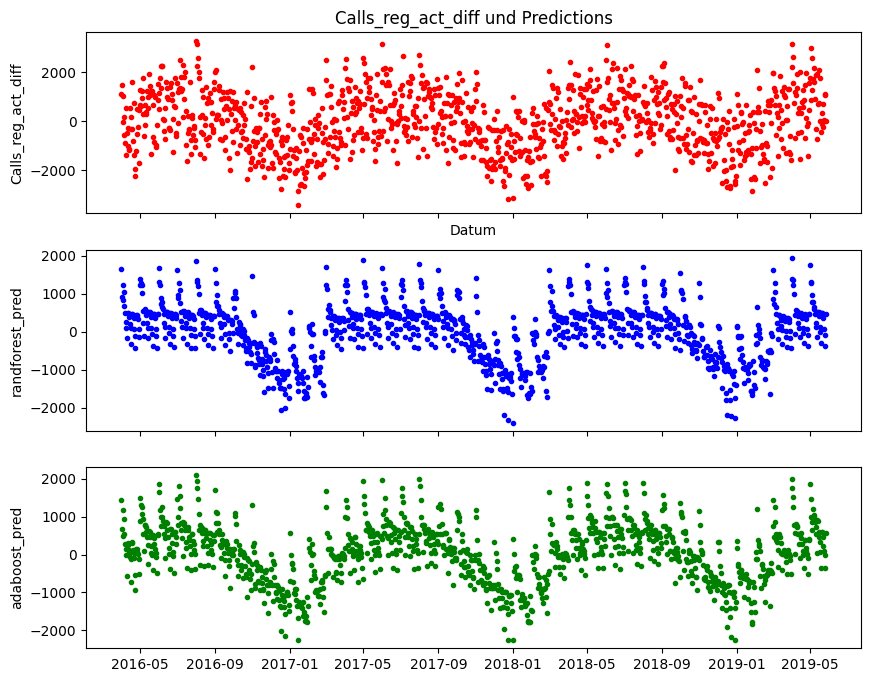

In [15]:
data_prep.plot_train_test(predictions, df_demand_predict)

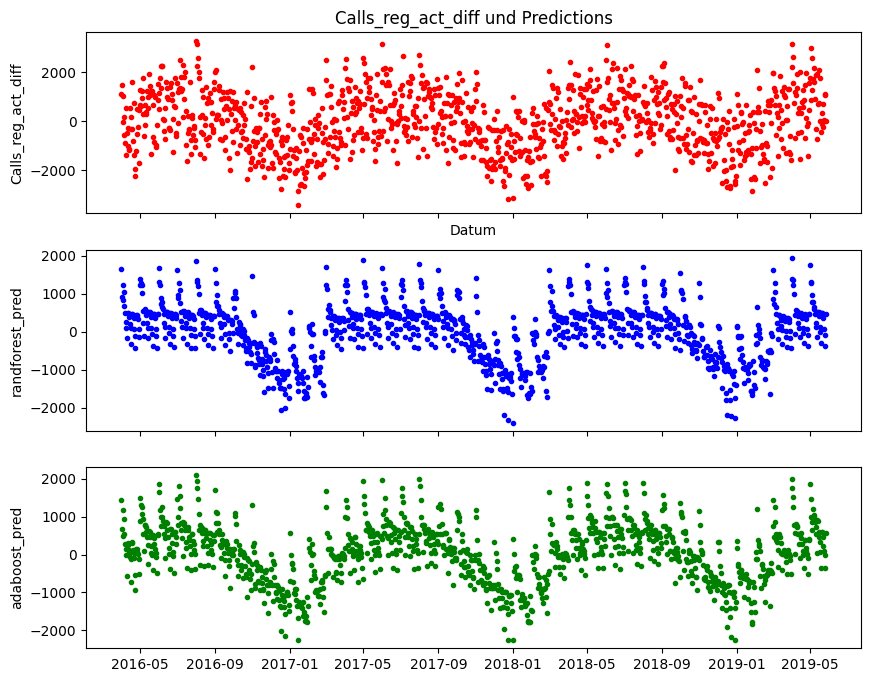

In [16]:
data_prep.plot_train_test(predictions, df_demand_predict)

##### Datenerfassung und -verständnis  




#### Processbeschreibung  

#### Beschreibung der relevanten Rollen  

#### Sammlung von Hilfsmitteln und Softwaretools  


Archiv

#### Data-Science-Lebenszyklus
- Geschäftsverständnis  
- Modellierung  
    - Merkmalsgenerierung
    - Training
    - Evaluierung
- Datenerfassung, und -verständnis  
    - Datenquelle
    
- Bereitstellung
    - Speicherung des Modells  
    - Webservice  
    - Anwendungen